In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pdb
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")


from cln import data
from cln import contamination
from cln.T_estimation import evaluate_estimate, AnchorPointsEstimation
from third_party import arc

In [2]:
# Define default parameters
exp_num = 701
data_name = 'synthetic1'
num_var = 20
K = 4
signal = 1
model_name = 'RFC'
epsilon = 0.2
nu = 0
contamination_model = "uniform"
n_train = 1000
n_cal = 5000
gamma = 0.03
seed = 1

# Define other constant parameters
batch_size = 20

In [3]:
# Initialize the data distribution
if data_name == "synthetic1":
    data_distribution = data.DataModel_1(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic2":
    data_distribution = data.DataModel_2(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic3":
    data_distribution = data.DataModel_3(K, num_var, signal=signal, random_state=seed)
else:
    print("Unknown data distribution!")
    sys.stdout.flush()
    exit(-1)

In [4]:
# Initialize noise contamination process
if contamination_model == "uniform":
    T = contamination.construct_T_matrix_simple(K, epsilon)
elif contamination_model == "block":
    T = contamination.construct_T_matrix_block(K, epsilon)
elif contamination_model == "RRB":
    T = contamination.construct_T_matrix_block_RR(K, epsilon, nu)
elif contamination_model == "random":
    T = contamination.construct_T_matrix_random(K, epsilon, random_state=seed)
else:
    print("Unknown contamination (M) model!")
    sys.stdout.flush()
    exit(-1)

In [5]:
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
elif model_name == 'MF':
    black_box = DummyClassifier(strategy="most_frequent")
elif model_name == 'SRC':
    black_box = DummyClassifier(strategy="stratified")
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [6]:
# Add important parameters to table of results
header = pd.DataFrame({'data':[data_name], 'num_var':[num_var], 'K':[K],
                       'signal':[signal], 'n_train':[n_train], 'n_cal':[n_cal],
                       'epsilon':[epsilon], 'nu':[nu], 'contamination':[contamination_model],
                       'model_name':[model_name],
                       'gamma':[gamma],
                       'seed':[seed]})

# Output file
outfile_prefix = "exp"+str(exp_num) + "/" + data_name + "_p" + str(num_var)
outfile_prefix += "_K" + str(K) + "_signal" + str(signal) + "_" + model_name
outfile_prefix += "_eps" + str(epsilon) + "_nu" + str(nu) + "_" + contamination_model
outfile_prefix += "_nt" + str(n_train) + "_nc" + str(n_cal) + "_gamma" + str(gamma) + "_seed" + str(seed)
print("Output file: {:s}.".format("results/"+outfile_prefix), end="\n")
sys.stdout.flush()

Output file: results/exp701/synthetic1_p20_K4_signal1_RFC_eps0.2_nu0_uniform_nt1000_nc5000_gamma0.03_seed1.


In [7]:
# Describe the experiment
def run_experiment(random_state):
    print("\nRunning experiment in batch {:d}...".format(random_state))
    sys.stdout.flush()

    # Generate a large data set
    print("\nGenerating data...", end=' ')
    sys.stdout.flush()
    data_distribution.set_seed(random_state+1)
    X, Y = data_distribution.sample(n_train+n_cal)
    print("Done.")
    sys.stdout.flush()

    # Generate the contaminated labels
    print("Generating contaminated labels...", end=' ')
    sys.stdout.flush()
    contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+2)
    Yt = contamination_process.sample_labels(Y)
    print("Done.")
    sys.stdout.flush()

    # Separate data into training and calibration
    X_train, X_cal, _, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+3)

    # Fit the point predictor on the training set
    black_box_pt = copy.deepcopy(black_box)
    black_box_pt.fit(X_train, Yt_train)

    methods = {
        "Anchor points Patrini": lambda: AnchorPointsEstimation(X_cal,Yt_cal, K, gamma, black_box_pt, empirical=False),

        "Anchor points empirical": lambda: AnchorPointsEstimation(X_cal,Yt_cal, K, gamma, black_box_pt, empirical=True)
    }

    # Initialize an empty list to store the evaluation results
    res = pd.DataFrame({})
    res_list = []

    # Estimate using all the clean/noisy labels correspondence
    T_hat_clean = np.zeros((K, K), dtype=float)
    for l in range(K):
        idx = (Y_cal == l)
        n_l = np.sum(idx)
        if n_l > 0:
            counts = np.bincount(Yt_cal[idx], minlength=K)
            T_hat_clean[:, l] = counts / n_l
        else:
            # Fallback if a class i does not appear in Y_train2
            T_hat_clean[:, l] = np.ones(K) / K
    col_sums = T_hat_clean.sum(axis=0, keepdims=True)
    T_hat_clean /= col_sums

    performances = evaluate_estimate(T, T_hat_clean)
    res_update = header.copy()
    res_update = res_update.assign(Method='Clean sample', n_eq=n_cal, **performances)
    res_list.append(res_update)


    # Estimate using n_equivalent samples with clean/noisy labels correspondence
    n_eq = int(np.round(n_cal * gamma))
    _, Y_cal_eq, _, Yt_cal_eq = train_test_split(Y_cal, Yt_cal, test_size=n_eq, random_state=random_state+3)
    T_hat_n_eq = np.zeros((K, K), dtype=float)
    for l in range(K):
        idx = (Y_cal_eq == l)
        n_l = np.sum(idx)
        if n_l > 0:
            counts = np.bincount(Yt_cal_eq[idx], minlength=K)
            T_hat_n_eq[:, l] = counts / n_l
        else:
            # Fallback if a class i does not appear in Y_train2
            T_hat_n_eq[:, l] = np.ones(K) / K
    col_sums = T_hat_n_eq.sum(axis=0, keepdims=True)
    T_hat_n_eq /= col_sums

    performances = evaluate_estimate(T, T_hat_n_eq)
    res_update = header.copy()
    res_update = res_update.assign(Method='Clean sample (n_eq)', n_eq=n_eq, **performances)
    res_list.append(res_update)

    # Loop through the anchor points methods, apply them, and evaluate the results
    for method_name, method_func in methods.items():
        print(f"Applying {method_name} method...", end=' ')
        sys.stdout.flush()

        # Initialize and apply the method
        method = method_func()
        T_hat, anchor_points_list = method.get_estimate()

        print("Done.")
        sys.stdout.flush()

        performances = evaluate_estimate(T, T_hat, Y_cal, Yt_cal, K, anchor_points_list)
        res_update = header.copy()
        res_update = res_update.assign(Method=method_name, n_eq=n_eq, **performances)
        res_list.append(res_update)

    # Combine all results into a single DataFrame
    res = pd.concat(res_list, ignore_index=True)
    #res = pd.DataFrame(res_list)
    #print(res)
    return res

In [8]:
# Run all experiments
results = pd.DataFrame({})
for batch in np.arange(1,batch_size+1):
    res = run_experiment(1000*seed+batch-1000)
    results = pd.concat([results, res])

    # Save results
    outfile = "results/" + outfile_prefix + ".txt"
    results.to_csv(outfile, index=False, float_format="%.5f")

print("\nFinished.\nResults written to {:s}\n".format(outfile))
sys.stdout.flush()


Running experiment in batch 1...

Generating data... Done.
Generating contaminated labels... Done.
Applying Anchor points Patrini method... Done.
Applying Anchor points empirical method... Done.

Running experiment in batch 2...

Generating data... Done.
Generating contaminated labels... Done.
Applying Anchor points Patrini method... Done.
Applying Anchor points empirical method... Done.

Running experiment in batch 3...

Generating data... Done.
Generating contaminated labels... Done.
Applying Anchor points Patrini method... Done.
Applying Anchor points empirical method... Done.

Running experiment in batch 4...

Generating data... Done.
Generating contaminated labels... Done.
Applying Anchor points Patrini method... Done.
Applying Anchor points empirical method... Done.

Running experiment in batch 5...

Generating data... Done.
Generating contaminated labels... Done.
Applying Anchor points Patrini method... Done.
Applying Anchor points empirical method... Done.

Running experiment 

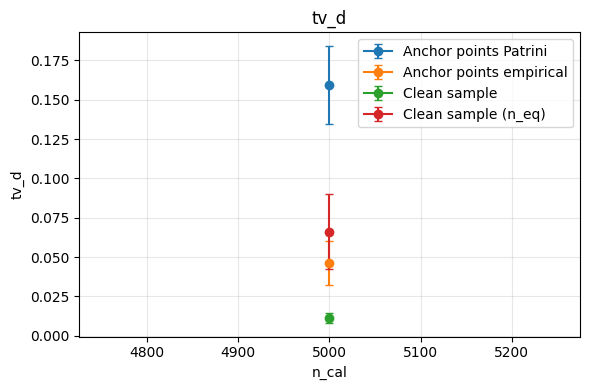

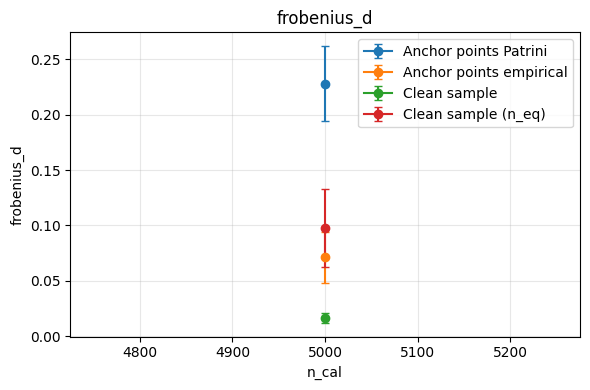

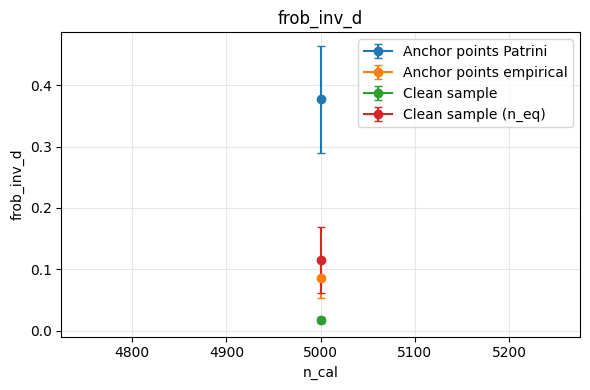

In [9]:
#summary = results.drop(columns=['seed']).groupby(['method', 'epsilon']).agg(['mean', 'std'])
summary = results.drop(columns=['seed']).replace({None: np.nan})
summary = summary.drop(columns=['model_name'])
summary = summary.drop(columns=['contamination'])
summary = summary.drop(columns=['data'])
summary = summary.groupby(['Method', 'n_cal']).agg(['mean', 'std'])
#summary = summary.groupby(['method', 'n_cal_eq']).agg(['mean', 'std'])


metric_cols = ['tv_d', 'frobenius_d', 'frob_inv_d']

for metric in metric_cols:
    mean_vals = summary[metric]['mean'].unstack('Method')
    std_vals  = summary[metric]['std'].unstack('Method')

    plt.figure(figsize=(6, 4))
    
    for method in mean_vals.columns:
        plt.errorbar(
            mean_vals.index,
            mean_vals[method],
            yerr=std_vals[method],
            marker='o',
            linestyle='-',
            capsize=3,
            label=method
        )
    
    plt.title(f"{metric}")
    plt.xlabel("n_cal")
    #plt.xlabel("n_cal_eq")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
